In [ ]:
from tensorflow import keras
from matplotlib import pyplot
import numpy as np
import cv2
from google.colab import files
from sklearn.utils import shuffle

from keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
# from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Reshape, Conv2DTranspose
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
import matplotlib.pyplot as plt
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.models import Model

In [ ]:
def define_discriminator(in_shape=(32,32,1), n_classes=69):
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 69*5)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(64, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(256, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# classifier
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
model = define_discriminator()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 345)       23805       input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 1024)      354304      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 32, 32, 1)]  0                                            
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
def define_generator(latent_dim, n_classes=69):
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 69*5)(in_label)
	# linear multiplication
	n_nodes = 4*4
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((4, 4, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))

	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4

	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((4, 4, 256))(gen)
	merge = Concatenate()([gen, li])
	# upsample to 8x8
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 16x16
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output layer
	out_layer = Conv2D(1, (3,3), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

In [ ]:
g_model = define_generator(256)
g_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 4096)         1052672     input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 345)       23805       input_3[0][0]                    
____________________________________________________________________________________________

In [ ]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
def load_real_samples(data):
  list_1 = [[element for element in upperElement] for upperElement in data['fea']]
  list_1_label = [[element for element in upperElement] for upperElement in data['gnd']]
  lab = np.array(list_1_label)
  #lab = lab.reshape(3332,)
  con_list = np.array(list_1)
  #print(con_list.shape)
  a = con_list[0:].reshape([con_list.shape[0],32,32])
  a = a.reshape([8222,32,32,1])
  X = a
  X = expand_dims(X, axis=-1)
  X1 = X.astype('float32')
  # scale from [0,255] to [-1,1]
  return [X1 , lab]

In [ ]:
def load_real_samples_new(data,lab):
  list_1 = data
  list_1_label = lab
  con_list = np.array(list_1)
  a = con_list[0:].reshape([con_list.shape[0],32,32])
  a = a.reshape([lab.shape[0],32,32,1])
  X = a
  X = expand_dims(X, axis=-1)
  X1 = X.astype('float32')
  return [X1 , lab]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/pie_4_training/

/content/drive/MyDrive/pie_4_training


In [ ]:
cd drive/MyDrive/pie_5_gen

/content/drive/MyDrive/pie_5_gen


/content/drive/MyDrive


In [ ]:
cd drive/MyDrive/pie_model/cgan/all_pie_model_cgan/

/content/drive/MyDrive/pie_model/cgan/all_pie_model_cgan


In [ ]:
from scipy.io import loadmat
# pie_5 = loadmat('/content/drive/MyDrive/pie/PIE05.mat')
pie_7 = loadmat('/content/drive/MyDrive/pie/PIE07.mat')
pie_9 = loadmat('/content/drive/MyDrive/pie/PIE09.mat')
pie_27 = loadmat('/content/drive/MyDrive/pie/PIE27.mat')
pie_29 = loadmat('/content/drive/MyDrive/pie/PIE29.mat')

In [ ]:
# list_1 = [[element for element in upperElement] for upperElement in pie_5['fea']]
# list_1_label = [[element for element in upperElement] for upperElement in pie_5['gnd']]

list_2 = [[element for element in upperElement] for upperElement in pie_7['fea']]
list_2_label = [[element for element in upperElement] for upperElement in pie_7['gnd']]

list_5 = [[element for element in upperElement] for upperElement in pie_9['fea']]
list_5_label = [[element for element in upperElement] for upperElement in pie_9['gnd']]

list_3 = [[element for element in upperElement] for upperElement in pie_27['fea']]
list_3_label = [[element for element in upperElement] for upperElement in pie_27['gnd']]

list_4 = [[element for element in upperElement] for upperElement in pie_29['fea']]
list_4_label = [[element for element in upperElement] for upperElement in pie_29['gnd']]

In [ ]:
fin = list_2+list_3+list_4+list_5

In [ ]:
lab = list_2_label+list_3_label+list_4_label+list_5_label

In [ ]:
lab = np.array(lab)


In [ ]:
lab.shape[0]

8222

In [ ]:
lab.reshape(8222,)

array([ 1,  1,  1, ..., 68, 68, 68], dtype=uint8)

In [ ]:
fin = list_2 + list_3 + list_4 + list_5

In [ ]:
fi = list_2 + list_3 + list_4 + list_5

In [ ]:
def generate_real_samples(dataset, n_samples):
  images, labels = dataset
  ix = randint(0, images.shape[0], n_samples)
  X, labels = images[ix], labels[ix]
  y = ones((n_samples, 1))
  return [X, labels], y

In [ ]:
def generate_latent_points(latent_dim, n_samples, n_classes=69):
  x_input = randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  labels = randint(0, n_classes, n_samples)
  return [z_input, labels]

In [ ]:
def generate_fake_samples(g_model, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = g_model.predict([z_input, labels_input])
	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [ ]:
def save_plot(examples, epoch, n=3):
  print(examples.shape)

  examples = (examples + 1) / 2.0
  for i in range(n * n):
    temp = examples[i].reshape([32,32])
    print(temp.shape)
    pyplot.subplot(n, n, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(temp)
    plt.show()
  filename = 'generated_plot_1_e%03d.png' % (epoch+1)
  pyplot.savefig(filename)
  # files.download(filename)
  pyplot.close()

In [ ]:
def plot(x_fake , g_model,n):
  for i in range(0,n):
    temp = x_fake[i].reshape([32,32])
    x = cv2.rotate(temp, cv2.cv2.ROTATE_90_CLOCKWISE)
    plt.imshow(x , cmap = "gray")
    plt.show()

In [ ]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  X_real, y_real = generate_real_samples(dataset, n_samples)

  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)

  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

  save_plot(x_fake, epoch)
  filename = 'generator_model_1_%03d.h5' % (epoch+1)
  g_model.save(filename)
  g_filename = 'discriminator_model_1_%03d.h5' % (epoch + 1)
  d_model.save(g_filename)
  print("saved file")
  # files.download(g_filename)

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim,loss_1,loss_2,loss_3, n_epochs=2000, n_batch=200):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
      loss_1.append(d_loss1)
      loss_2.append(d_loss2)
      loss_3.append(g_loss)
      print('>%d, %d/%d, d1=%.3f ,d2=%.3f g=%.3f' %
      (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    g_model.save('cgan_generator_'+str(i)+'.h5')

In [ ]:
latent_dim = 256
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples_new(fin,lab)
loss_1=list()
loss_2=list()
loss_3=list()
train(g_model, d_model, gan_model, dataset,latent_dim,loss_1,loss_2,loss_3 )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Streaming output truncated to the last 5000 lines.
>1074, 14/41, d1=0.323 ,d2=0.243 g=6.083
>1074, 15/41, d1=0.510 ,d2=0.391 g=7.739
>1074, 16/41, d1=0.307 ,d2=0.269 g=7.524
>1074, 17/41, d1=0.347 ,d2=0.370 g=3.721
>1074, 18/41, d1=0.265 ,d2=0.296 g=9.923
>1074, 19/41, d1=0.349 ,d2=0.257 g=6.281
>1074, 20/41, d1=0.323 ,d2=0.391 g=2.557
>1074, 21/41, d1=0.352 ,d2=0.274 g=7.076
>1074, 22/41, d1=0.325 ,d2=0.309 g=9.019
>1074, 23/41, d1=0.302 ,d2=0.242 g=5.925
>1074, 24/41, d1=0.371 ,d2=0.383 g=4.817
>1074, 25/41, d1=0.279 ,d2=0.361 g=5.524
>1074, 26/41, d1=0.278 ,d2=0.167 g=5.803
>1074, 27/41, d1=0.363 ,d2=0.239 g=6.295
>1074, 28/41, d1=0.251 ,d2=0.300 g=5.235
>1074, 29/41, d1=0.231 ,d2=0.369 g=8.350
>1074, 30/41, d1=0.290 ,d2=0.352 g=3.738
>1074, 31/41, d1=0.376 ,d2=0.281 g=5.103
>1074, 32/41, d1=0.308 ,d2=0.349 g=8.862
>1074, 33/41, d1=0.374 ,d2=0.144 g=7.643
>1074, 34/41, d1=0.339 ,d2=0.285 g=4.898
>1074, 35/41, d1=0.243 ,d2=0.347 g=11.935
>1074, 36/41, d1=0.281 ,d2=0.308 g=6.619
>1074

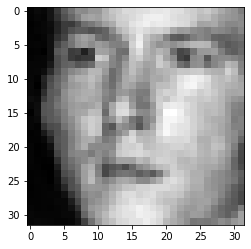

In [ ]:
temp = generate_latent_points(256, 1)
g_model = load_model('cgan_generator_1999.h5')
x = g_model.predict(temp)
x = x[0].reshape([32,32])
x = cv2.rotate(x, cv2.cv2.ROTATE_90_CLOCKWISE)
plt.imshow(x , cmap = "gray")
plt.show()


In [ ]:
from numpy import asarray
def generate_latent_points(latent_dim, n_samples, n_classes=69):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		pyplot.imshow(cv2.rotate(examples[i, :, :, 0], cv2.cv2.ROTATE_90_CLOCKWISE),cmap="gray")
	pyplot.show()

# load model
for i in range(1990,2000):
  model = load_model('cgan_generator_'+str(i)+'.h5')
  # generate images
  latent_points, labels = generate_latent_points(256,100)
  # specify labels
  labels = asarray([x for _ in range(10) for x in range(10)])
  # generate images
  X  = model.predict([latent_points, labels])
  # scale from [-1,1] to [0,1]
  #X = (X + 1) / 2.0
  # plot the result
  save_plot(X, 5)

In [ ]:
def display(examples,n ,m):
  examples = (examples + 1) / 2.0
  for i in range(n * m):
    temp = examples[i].reshape([32,32])
    temp = cv2.rotate(temp, cv2.cv2.ROTATE_90_CLOCKWISE)
    pyplot.subplot(n, m, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(temp,cmap = "gray")
  # plt.savefig("new_1.png")
  plt.show()

  # files.download(filename)
  pyplot.close()

In [ ]:
pie_5['gnd'].shape

(3332, 1)

In [ ]:
l = loadmat("fake_images_pie_5.mat")

In [ ]:
pwd

'/content/drive/My Drive/pie_5_gen'

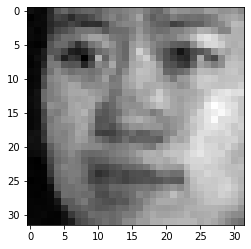

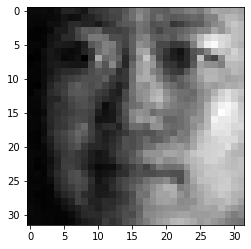

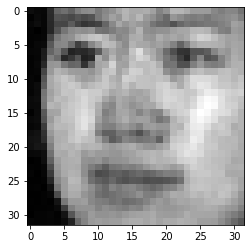

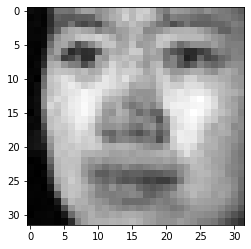

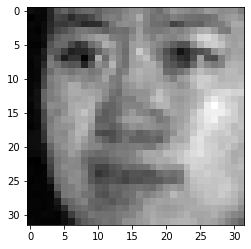

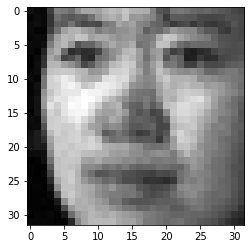

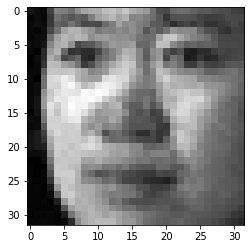

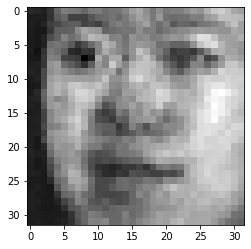

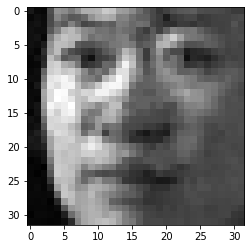

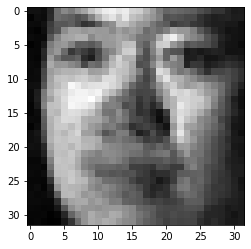

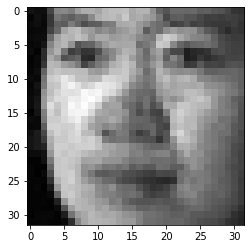

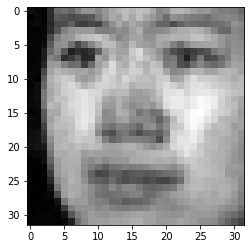

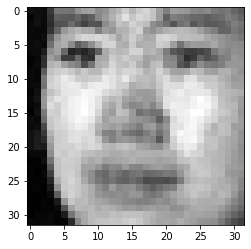

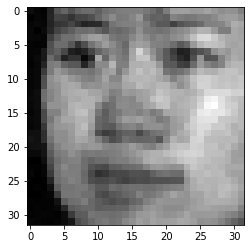

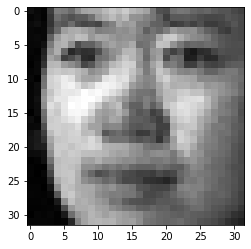

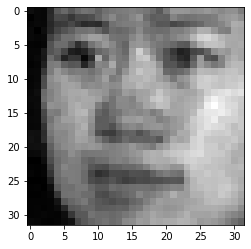

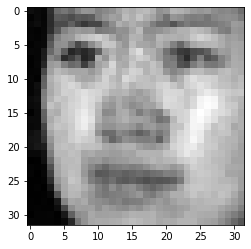

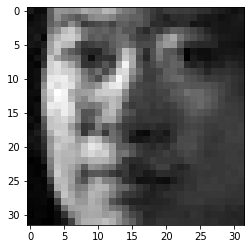

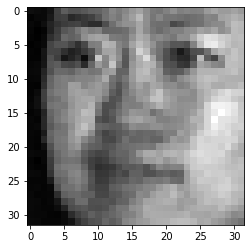

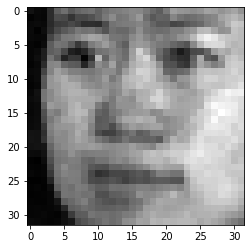

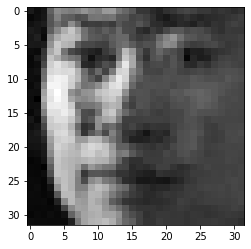

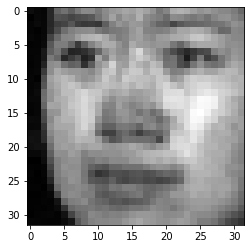

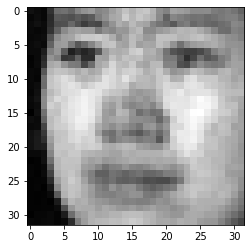

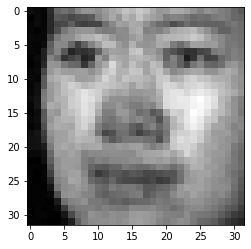

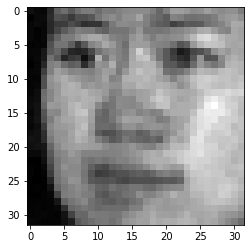

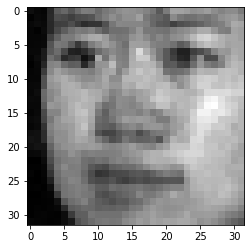

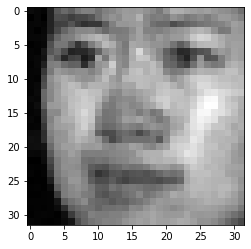

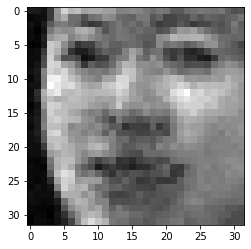

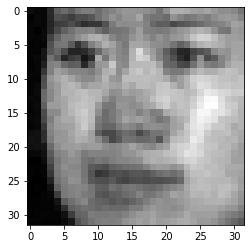

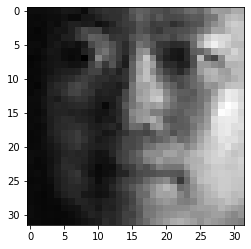

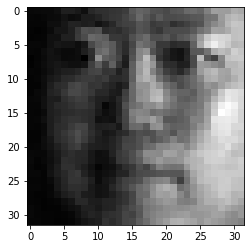

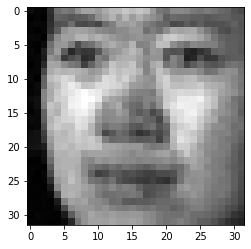

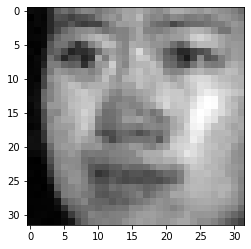

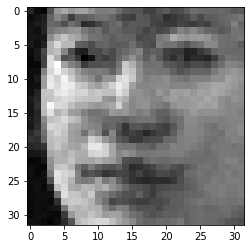

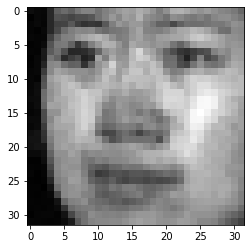

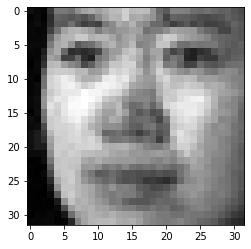

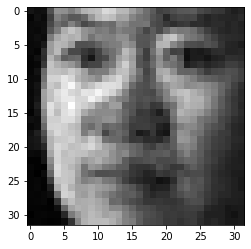

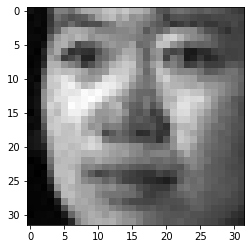

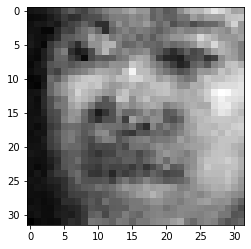

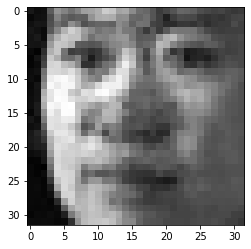

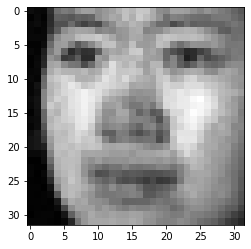

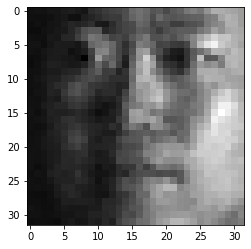

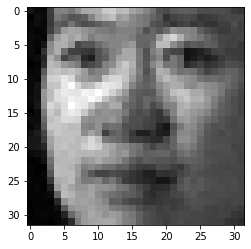

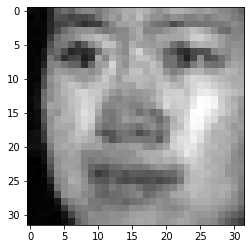

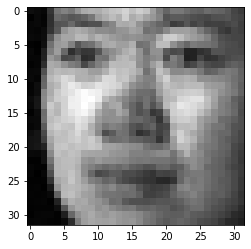

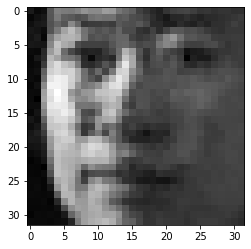

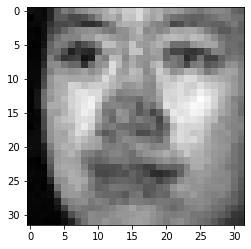

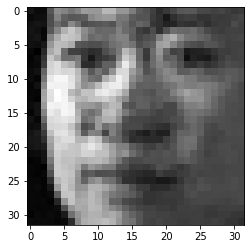

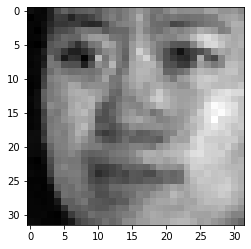

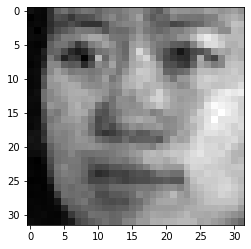

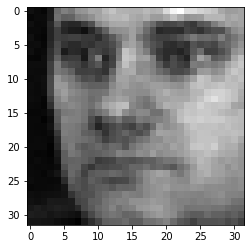

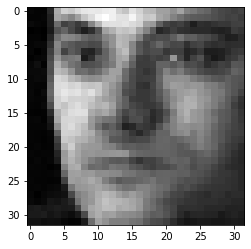

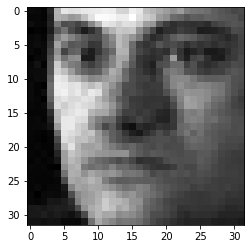

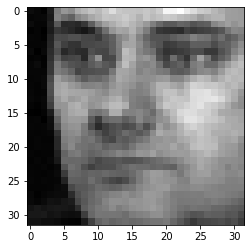

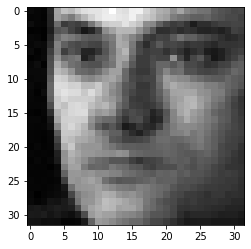

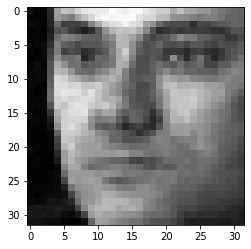

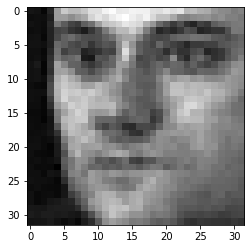

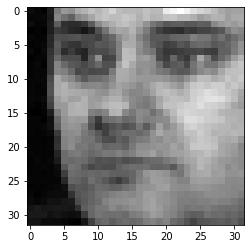

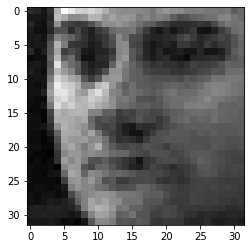

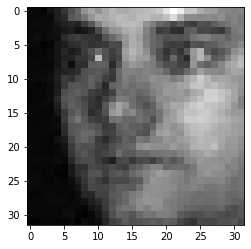

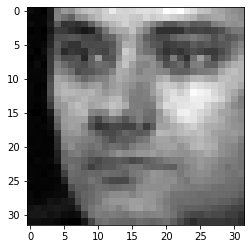

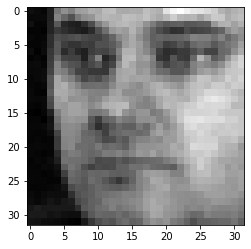

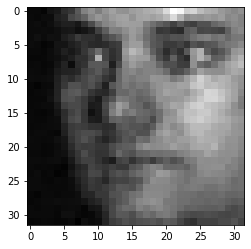

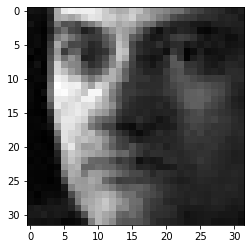

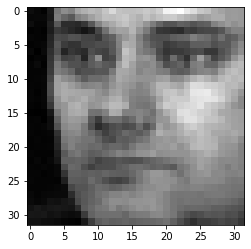

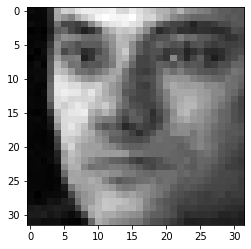

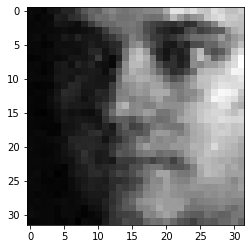

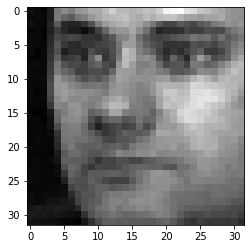

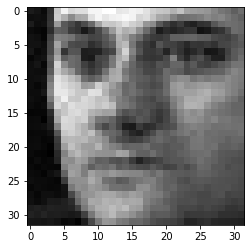

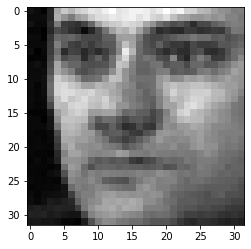

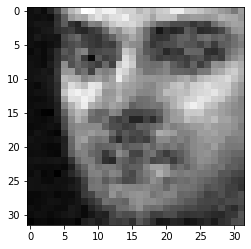

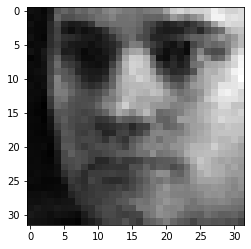

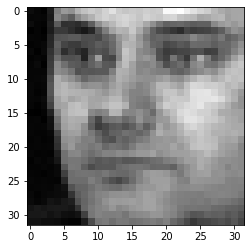

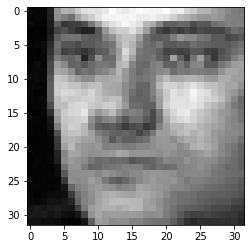

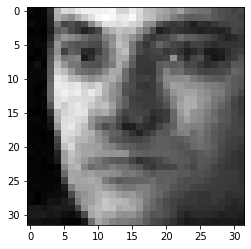

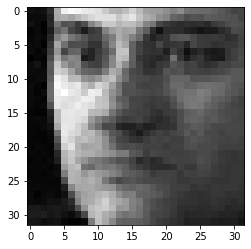

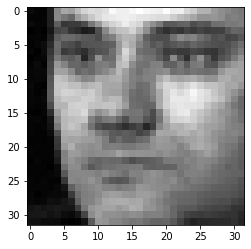

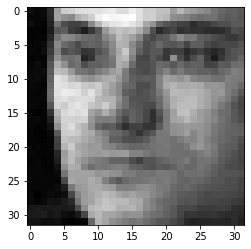

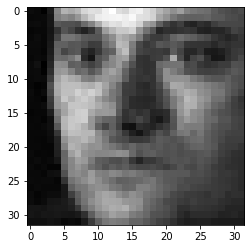

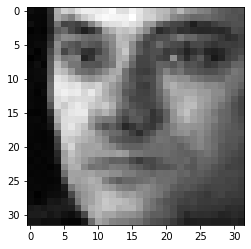

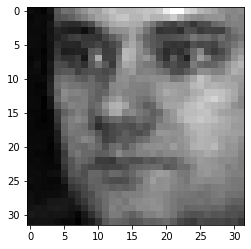

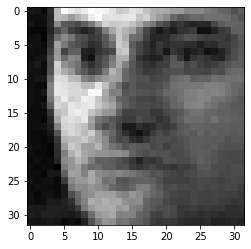

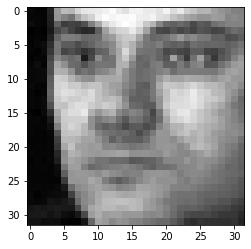

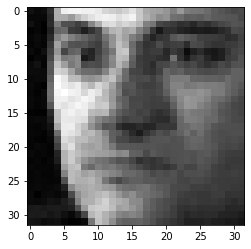

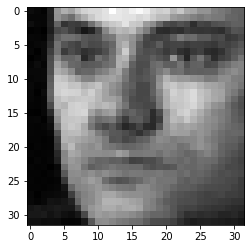

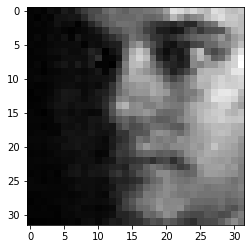

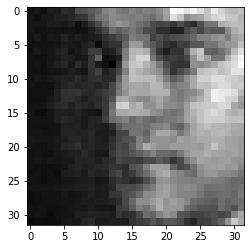

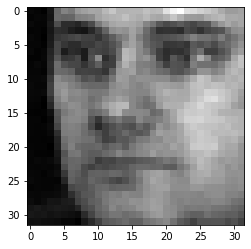

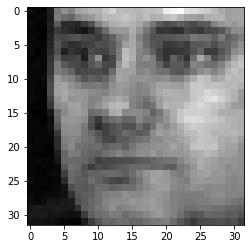

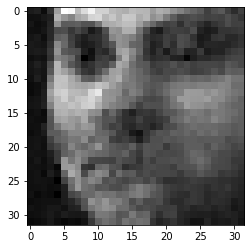

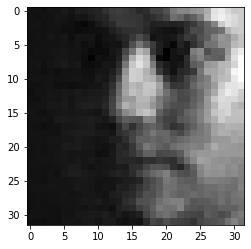

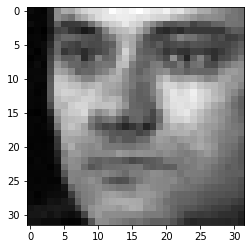

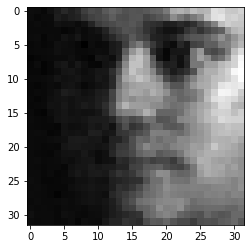

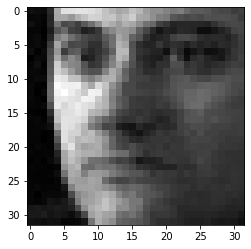

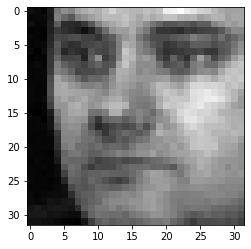

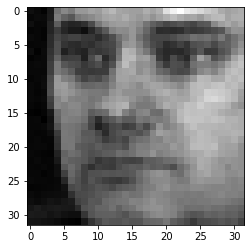

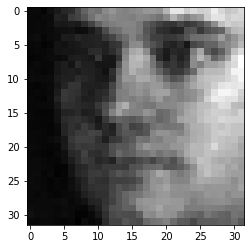

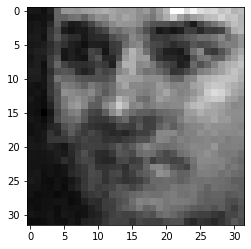

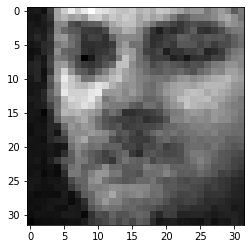

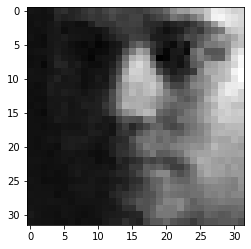

In [ ]:
for i in range(100):
  var = i
  a = l["fea"][var].reshape(32,32)
  b = l["gnd"][var]
  a = cv2.rotate(a, cv2.cv2.ROTATE_90_CLOCKWISE)
  pyplot.imshow(a,cmap = "gray")
  plt.show()
  # plt.savefig("new_"+str(i)+".png")

[2]


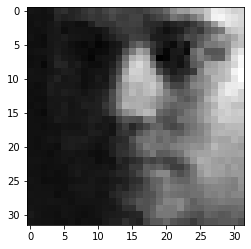

In [ ]:
kl = np.full((100,1),1,dtype=int)
for j in range(2,69):
  one = np.full((100,1),j,dtype=int)
  kl = np.concatenate((kl,one))

In [ ]:
kl.shape

(6800, 1)

In [ ]:
cd all_pie_model_cgan/

/content/drive/My Drive/pie_model/cgan/all_pie_model_cgan


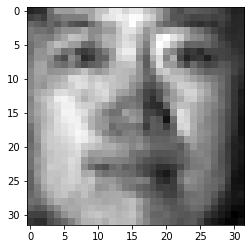

In [ ]:
# !cd ..
# !cd btp_2/
model = load_model('cgan_generator_1999.h5')
latent_points, labels = generate_latent_points(256,4)
labels = np.asarray([x for _ in range(1,3) for x in range(1,3)])
X  = model.predict([latent_points, labels])
# o = np.array(X).reshape(6800,1024)
# print(o.shape)
# display(X, 10, 3)
lo = X[0].reshape(32,32)
lo = cv2.rotate(lo, cv2.cv2.ROTATE_90_CLOCKWISE)
# k = k + 1
pyplot.imshow(lo,cmap = "gray")
# plt.savefig("new_1.png")
plt.show()

# files.download(filename)
pyplot.close()


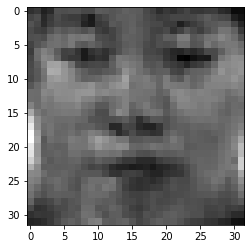

In [ ]:
model = load_model('cgan_generator_1999.h5')
latent_points, labels = generate_latent_points(256,6800)
labels = np.asarray([x for _ in range(1,101) for x in range(1,69)])
X  = model.predict([latent_points, labels])
o = np.array(X).reshape(6800,1024)
print(o.shape)



In [ ]:
model = load_model('cgan_generator_1191.h5')
latent_points, labels = generate_latent_points(256,6800)
labels = np.asarray([x for _ in range(1,101) for x in range(1,69)])
X  = model.predict([latent_points, labels])
o = np.array(X).reshape(6800,1024)
print(o.shape)
ret = o[0].reshape(1,1024)
for clas in range(0,68):
  for ind in range(0,100):
    if(clas == 0 and ind == 0):
      print("Do Nothing")
    else:
      ret = np.append(ret,o[clas+ (ind*68) ].reshape(1,1024),axis = 0)

(6800, 1024)
Do Nothing


In [ ]:
ret = o[0].reshape(1,1024)
for clas in range(0,68):
  for ind in range(0,100):
    if(clas == 0 and ind == 0):
      print("Do Nothing")
    else:
      ret = np.append(ret,o[clas+ (ind*68) ].reshape(1,1024),axis = 0)

j


In [ ]:
# ret = np.empty(shape=[0,0])
ret.shape

(6800, 1024)

In [ ]:
k = 0
for i in range(10):
  a = ret[99+k].reshape(32,32)
  a = cv2.rotate(a, cv2.cv2.ROTATE_90_CLOCKWISE)
  k = k + 1
  pyplot.imshow(a,cmap = "gray")
  # plt.savefig("new_1.png")
  plt.show()

  # files.download(filename)
pyplot.close()


In [ ]:
import scipy.io
from scipy.io import loadmat
# scipy.io.savemat('fake_images_pie_except_5.mat', mdict={'fea': ret, 'gnd':kl })

In [ ]:
cd fake_images_pics/

/content/drive/My Drive/pie_model/cgan/fake_images_pics


In [ ]:
scipy.io.savemat('fake_images_pie_5.mat', mdict={'fea': ret, 'gnd':kl })

In [ ]:
test = loadmat('fake_images.mat')

In [ ]:
# clas = 0
# num = 0
for iter in range(6701,6800):
  # if(iter % 100 == 0):
  #   clas += 1
  #   num = 0
  temp = cv2.rotate(test['fea'][iter].reshape(32,32), cv2.cv2.ROTATE_90_CLOCKWISE)
  pyplot.imshow(temp,cmap = "gray")
  print(test['gnd'][iter])
  # plt.savefig(str(clas) + "_" + str(num) + ".png")
  # num += 1

  plt.show()


pyplot.close()

In [ ]:
ls

fake_images.mat


In [ ]:
clas = 0
num = 0
for iter in range(0,6800):
  if(iter % 100 == 0):
    clas += 1
    num = 0
  temp = cv2.rotate(test['fea'][iter].reshape(32,32), cv2.cv2.ROTATE_90_CLOCKWISE)
  pyplot.imshow(temp,cmap = "gray")
  plt.savefig(str(clas) + "_" + str(num) + ".png")
  num += 1

  # plt.show()


pyplot.close()

In [ ]:
cd fake_images_pics/

/content/drive/My Drive/pie_model/cgan/fake_images_pics


In [ ]:
#########################################

In [ ]:
model = load_model('cgan_generator_1493.h5')
latent_points, labels = generate_latent_points(256,3400)
labels = np.asarray([x for _ in range(1,51) for x in range(1,69)])
X  = model.predict([latent_points, labels])
# display(X,5,5)
o = np.array(X).reshape(3400,1024)
# print(o.shape)




In [ ]:
o.shape

(3400, 1024)

In [ ]:
kl.shape

(3400, 1)

In [ ]:
ret = o[0].reshape(1,1024)
for clas in range(0,68):
  for ind in range(0,50):
    if(clas == 0 and ind == 0):
      print("Do Nothing")
    else:
      ret = np.append(ret,o[clas+ (ind*68) ].reshape(1,1024),axis = 0)

Do Nothing


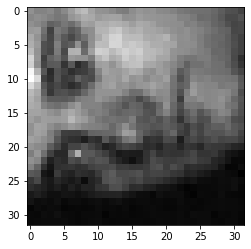

In [ ]:
plt.imshow(ret[62].reshape(32,32),cmap="gray")

In [ ]:
scipy.io.savemat('fake_images_pie_5.mat', mdict={'fea': ret, 'gnd':kl })

In [ ]:
cd fake_images_pics/

/content/drive/My Drive/pie_model/cgan/fake_images_pics


In [ ]:
l = loadmat("pie_05_fake.mat")

(3400, 1024)

In [ ]:
a = l["fea"][1].reshape(32,32)

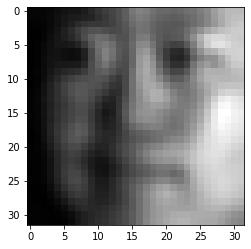

In [ ]:
a = cv2.rotate(a, cv2.cv2.ROTATE_90_CLOCKWISE)
blur = cv2.blur(a,(3,3))
pyplot.imshow(blur,cmap="gray")

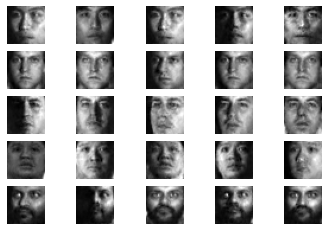

In [ ]:
l = loadmat("fake_images.mat")

k = 500
for i in range(5):
  for j in range(5):
    a = l['fea'][k + i*5 + j  +10 + 1].reshape(32,32)
    a = cv2.rotate(a, cv2.cv2.ROTATE_90_CLOCKWISE)
    plt.subplot(5,5,i*5 + j + 1)
    plt.axis('off')
    pyplot.imshow(a,cmap="gray")

  k += 100
# pyplot.imshow(a,cmap="gray")

In [ ]:
l = loadmat("fake_images_pie_except_5.mat")

In [ ]:
l["fea"].shape

(6800, 1024)

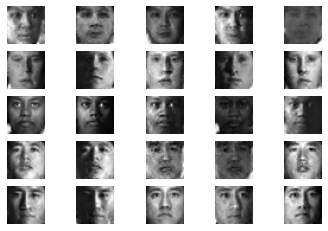

In [ ]:
k = 4000
for i in range(5):
  for j in range(5):
    a = l['fea'][k + i*5 + j + 1].reshape(32,32)
    a = cv2.rotate(a, cv2.cv2.ROTATE_90_CLOCKWISE)
    plt.subplot(5,5,i*5 + j + 1)
    plt.axis('off')
    pyplot.imshow(a,cmap="gray")

  k += 100
# pyplot.imshow(a,cmap="gray")

[2]


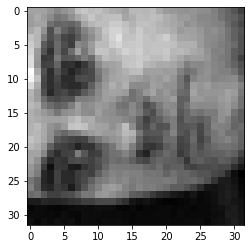

[2]


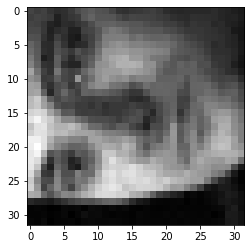

[2]


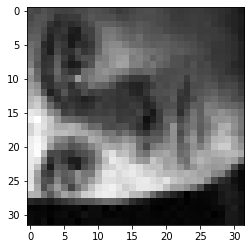

[2]


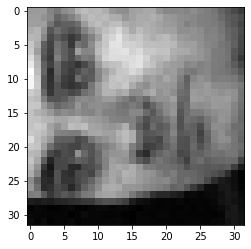

[2]


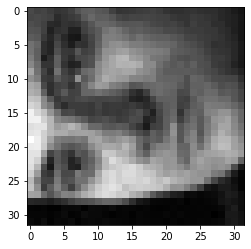

[2]


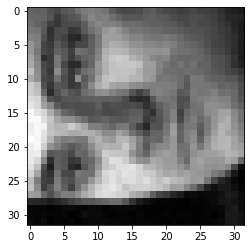

[2]


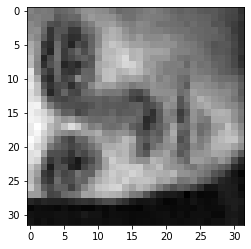

[2]


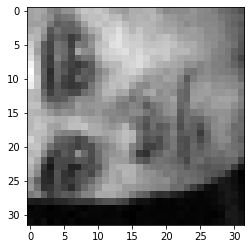

[2]


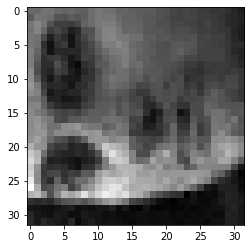

[2]


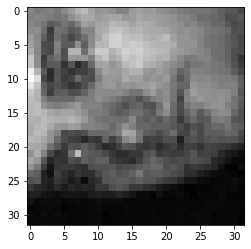

[2]


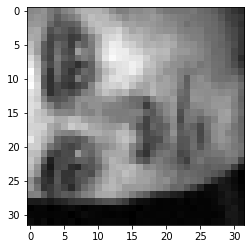

[2]


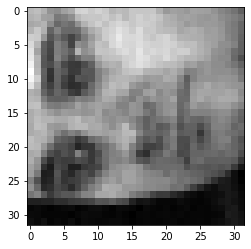

[2]


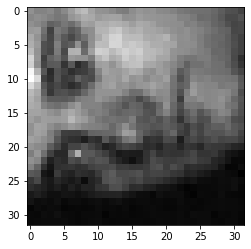

[2]


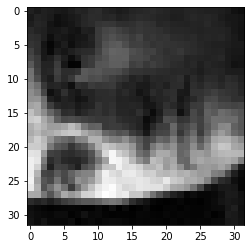

[2]


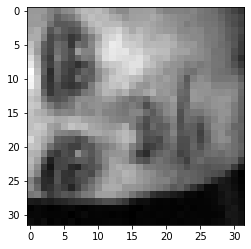

[2]


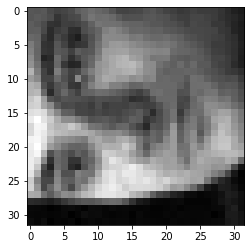

[2]


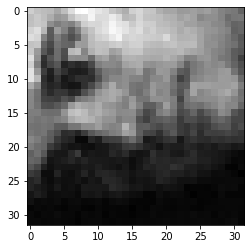

[2]


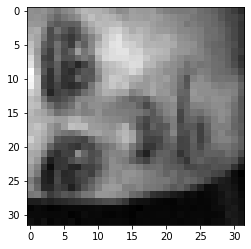

[2]


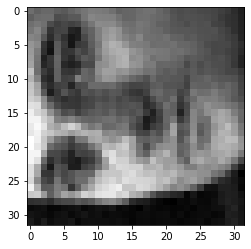

[2]


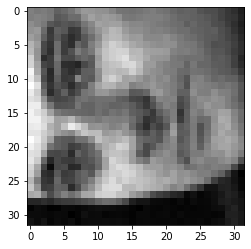

[2]


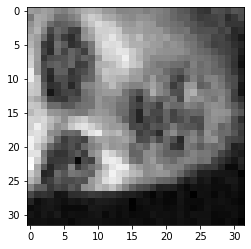

[2]


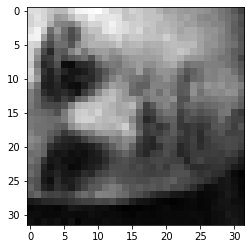

[2]


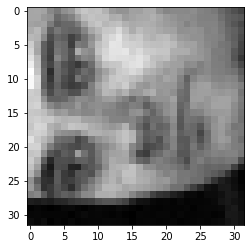

[2]


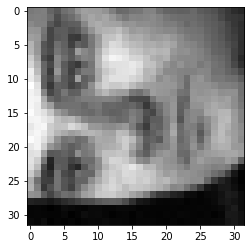

[2]


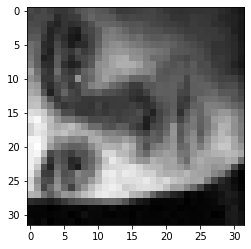

[2]


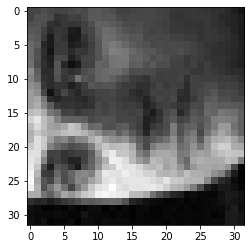

[2]


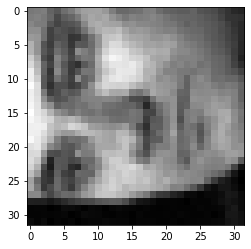

[2]


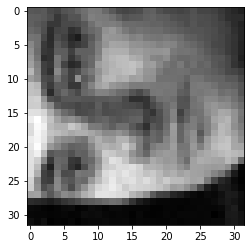

[2]


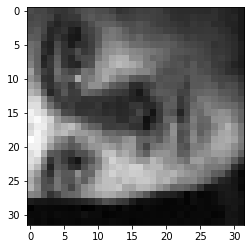

[2]


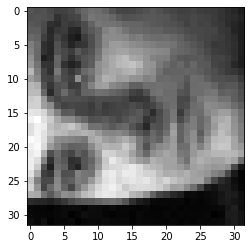

[2]


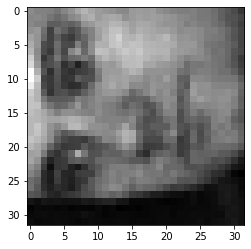

[2]


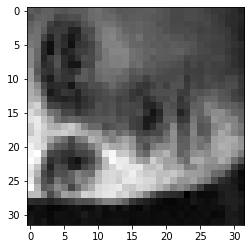

[2]


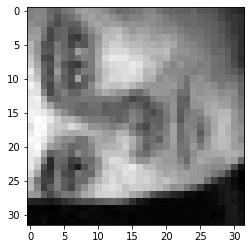

[2]


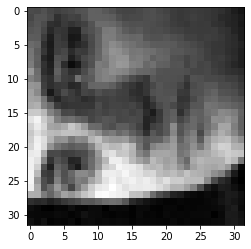

[2]


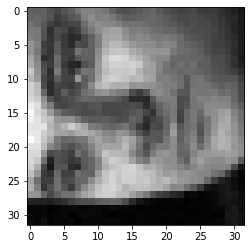

[2]


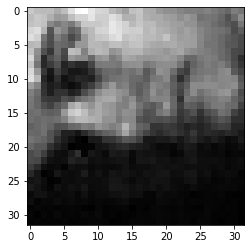

[2]


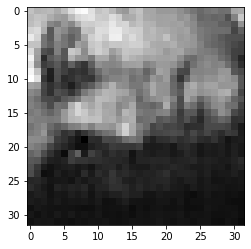

[2]


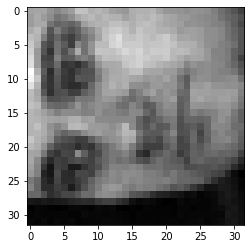

[2]


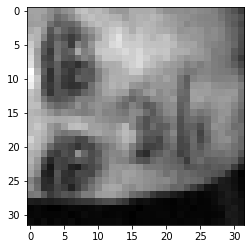

[2]


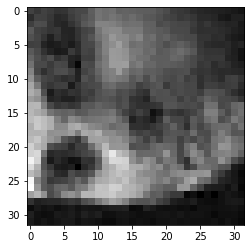

[2]


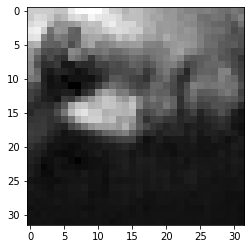

[2]


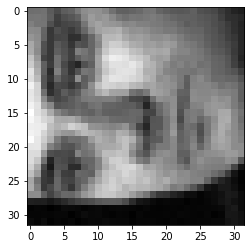

[2]


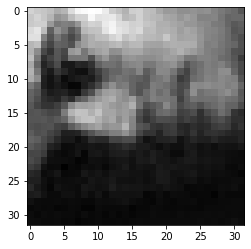

[2]


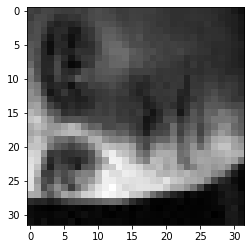

[2]


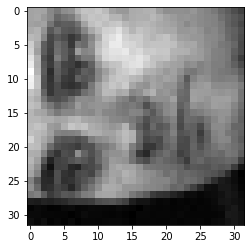

[2]


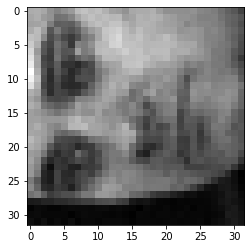

[2]


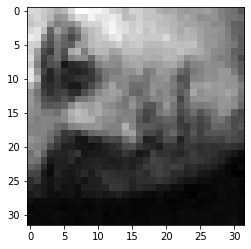

[2]


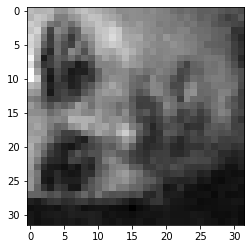

[2]


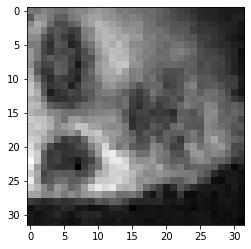

[2]


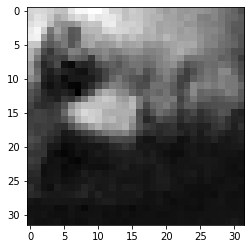

In [ ]:
for i in range(50,100):
  a = l['fea'][i].reshape(32,32)
  pyplot.imshow(a,cmap = "gray")
  print(l['gnd'][i])
  # plt.savefig("new_1.png")
  plt.show()

  # files.download(filename)
pyplot.close()